<a href="https://colab.research.google.com/github/EricX003/CS371-FINAL-PROJECT/blob/main/POS_ngram6/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import gc

from nltk import pos_tag
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from random import random

import torch
from transformers import BartForConditionalGeneration, BartTokenizer

import csv
import time

from nltk.util import ngrams
from collections import Counter
import heapq

from string import punctuation
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files
from torchvision import transforms
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import gspread

auth.authenticate_user()

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [141]:
tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
cost = lambda x, t: (2*((x-t)/(x+t)))**2

In [142]:
idx = 0
temp = dict()
offset = 65
for tag in tags:
    if offset + idx == 90:
        offset = 72
    temp[tag] = chr(offset + idx)
    idx += 1
tags = temp

In [143]:
print(tags)

{'CC': 'A', 'CD': 'B', 'DT': 'C', 'EX': 'D', 'FW': 'E', 'IN': 'F', 'JJ': 'G', 'JJR': 'H', 'JJS': 'I', 'LS': 'J', 'MD': 'K', 'NN': 'L', 'NNS': 'M', 'NNP': 'N', 'NNPS': 'O', 'PDT': 'P', 'POS': 'Q', 'PRP': 'R', 'PRP$': 'S', 'RB': 'T', 'RBR': 'U', 'RBS': 'V', 'RP': 'W', 'SYM': 'X', 'TO': 'Y', 'UH': 'a', 'VB': 'b', 'VBD': 'c', 'VBG': 'd', 'VBN': 'e', 'VBP': 'f', 'VBZ': 'g', 'WDT': 'h', 'WP': 'i', 'WP$': 'j', 'WRB': 'k'}


In [ ]:
def generate_profiles(csv_path, n):
    
    profiles = [dict() for i in range(150)]

    data = pd.read_csv(csv_path, skiprows = 1)

    for index, row in data.iterrows():

        text = row[1]
        text = [char for char in text]
        num_tokens = len(text)

        profile = profiles[int(row[0])]
        '''
        words = word_tokenize(text)
        pos_tokens = pos_tag(words)

        profile = profiles[int(row[0])]

        num_tokens = len(pos_tokens)
        
        for idx in range(num_tokens):
            pos_tokens[idx] = pos_tokens[idx][1]

        for idx in range(num_tokens - n + 1):
            ngram = ' '.join(pos_tokens[idx : idx + n])
            profile[ngram] = profile[ngram] + 1 if ngram in profile else 1
        '''

        for idx in range(num_tokens - n + 1):
            ngram = ''.join(text[idx : idx + n])
            profile[ngram] = profile[ngram] + 1 if ngram in profile else 1

        profiles[int(row[0])] = profile

    return profiles

def generate_single_profile(text, n):

    profile = dict()
    text = [char for char in text]
    num_tokens = len(text)
    for idx in range(num_tokens - n + 1):
        ngram = ''.join(text[idx : idx + n])
        profile[ngram] = profile[ngram] + 1 if ngram in profile else 1
    '''
    words = word_tokenize(text)
    pos_tokens = pos_tag(words)

    num_tokens = len(pos_tokens)

    for idx in range(num_tokens):
        pos_tokens[idx] = pos_tokens[idx][1]

    for idx in range(num_tokens - n + 1):
        ngram = ' '.join(pos_tokens[idx : idx + n])
        
        profile[ngram] = profile[ngram] + 1 if ngram in profile else 1
    '''
    return profile

def convert_to_prop(profiles):
    for idx in range(len(profiles)):
        profile = profiles[idx]
        total = sum(profile.values())
        profile = {key: value / total for key, value in profile.items()}
        profiles[idx] = profile
    
    return profiles


In [ ]:
def return_best_pos_n_grams(n, L, text):

    words = word_tokenize(text)
    pos_tokens = pos_tag(words)

    text = [tup[1] for tup in pos_tokens]
    text = ' '.join(text)

    n_grams = ngrams(text, n)

    data = dict(Counter(n_grams))
    list_ngrams = heapq.nlargest(L, data.keys(), key=lambda k: data[k])
    return list_ngrams


def return_best_n_grams(n, L, text):
    bigrams = ngrams(text, n)

    data = dict(Counter(bigrams))
    list_ngrams = heapq.nlargest(L, data.keys(), key=lambda k: data[k])
    return list_ngrams

def find_freq_n_gram_in_txt(text, pos_text, n_gram_lengths, n_grams, pos_n_gram_lengths, pos_n_grams):
    
    to_ret = []

    for idx in range(len(n_grams)):
        num_ngrams = len(Counter(ngrams(text, n_gram_lengths[idx])))

        for n_gram in n_grams[idx]: 
            to_ret.append(text.count(''.join(n_gram))/num_ngrams)

    for idx in range(len(pos_n_grams)):
        num_pos_ngrams = len(Counter(ngrams(pos_text, pos_n_gram_lengths[idx])))

        for pos_n_gram in pos_n_grams[idx]: 
            to_ret.append(pos_text.count(''.join(pos_n_gram))/num_pos_ngrams)

    return to_ret

 


In [ ]:
model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')

def obsfucate(target, n, M, costs, prediction):

    targets = costs[prediction]
    targets = targets[targets[ : , 1 ].argsort()]

    targets = [row[1] for row in targets]
    targets = targets[ :M]

    sentences = sent_tokenize(target)

    text = ''

    for sentence in sentences:
        words = word_tokenize(sentence)
        tags = pos_tag(words)
        tags = ''.join(tags)

        if any([n_gram in tags for n_gram in targets]):
            batch = tokenizer(sentence, return_tensors='pt')
            generated_ids = model.generate(batch['input_ids'])
            text += tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        else:
            text += sentence

    return text

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/332 [00:00<?, ?B/s]

In [ ]:
authors = ['allen-p', 'arnold-j', 'arora-h', 'badeer-r', 'bailey-s', 'bass-e', 'baughman-d', 'beck-s', 'benson-r', 'blair-l', 'brawner-s', 'buy-r', 'campbell-l', 'carson-m', 'cash-m', 'causholli-m', 'corman-s', 'crandell-s', 'cuilla-m', 'dasovich-j', 'davis-d', 'dean-c', 'delainey-d', 'derrick-j', 'dickson-s', 'donoho-l', 'donohoe-t', 'dorland-c', 'ermis-f', 'farmer-d', 'fischer-m', 'forney-j', 'fossum-d', 'gang-l', 'gay-r', 'geaccone-t', 'germany-c', 'gilbertsmith-d', 'giron-d', 'griffith-j', 'grigsby-m', 'guzman-m', 'haedicke-m', 'hain-m', 'harris-s', 'hayslett-r', 'heard-m', 'hendrickson-s', 'hernandez-j', 'hodge-j', 'holst-k', 'horton-s', 'hyatt-k', 'hyvl-d', 'jones-t', 'kaminski-v', 'kean-s', 'keavey-p', 'keiser-k', 'king-j', 'kitchen-l', 'kuykendall-t', 'lavorato-j', 'lay-k', 'lenhart-m', 'lewis-a', 'linder-e', 'lokay-m', 'lokey-t', 'love-p', 'lucci-p', 'maggi-m', 'mann-k', 'martin-t', 'may-l', 'mccarty-d', 'mcconnell-m', 'mckay-b', 'mckay-j', 'mclaughlin-e', 'merriss-s', 'meyers-a', 'mims-thurston-p', 'motley-m', 'neal-s', 'nemec-g', 'panus-s', 'parks-j', 'pereira-s', 'perlingiere-d', 'phanis-s', 'pimenov-v', 'platter-p', 'presto-k', 'quenet-j', 'quigley-d', 'rapp-b', 'reitmeyer-j', 'richey-c', 'ring-a', 'ring-r', 'rodrique-r', 'rogers-b', 'ruscitti-k', 'sager-e', 'saibi-e', 'salisbury-h', 'sanchez-m', 'sanders-r', 'scholtes-d', 'schoolcraft-d', 'schwieger-j', 'scott-s', 'semperger-c', 'shackleton-s', 'shankman-j', 'shapiro-r', 'shively-h', 'skilling-j', 'slinger-r', 'smith-m', 'solberg-g', 'south-s', 'staab-t', 'stclair-c', 'steffes-j', 'stepenovitch-j', 'stokley-c', 'storey-g', 'sturm-f', 'swerzbin-m', 'symes-k', 'taylor-m', 'tholt-j', 'thomas-p', 'townsend-j', 'tycholiz-b', 'ward-k', 'watson-k', 'weldon-c', 'whalley-g', 'whalley-l', 'white-s', 'whitt-m', 'williams-j', 'williams-w3', 'wolfe-j', 'ybarbo-p', 'zipper-a', 'zufferli-j']
temp = dict()

for idx in range(len(authors)):
    temp[authors[idx]] = idx

authors = temp

In [ ]:
cnt = 0
to_write = []

for index, row in enron.iterrows():
    folder = row[0]
    if 'sent' in folder:
        if not '-- Forwarded' in row[1]:
            email = row[1].split('\n')
            email = ' '.join(email[16: ])
            if len(email.split(" ")) > 100:
                to_write.append([authors[row[0].split('/', 1)[0]], email])
            
with open('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/smaller.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(['AuthorID', 'Message'])

    writer.writerows(to_write)


In [ ]:
small = pd.read_csv('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/smaller.csv')
print(len(small.index))

43315


In [ ]:
enron = pd.read_csv('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/emails.csv')

In [ ]:
temp = enron
temp = temp.reset_index()

idx = 0
authors = []

import csv 

for index, row in temp.iterrows():
    email = row[2].split('\n')
    email = email[16: ]
    email = ' '.join(email)
    if not len(email.split(' ')) < 10:
        author = row[1].split('/', 1)
        author = author[0]

        temp.iloc[index, 1] = author
        temp.iloc[index, 2] = email

        if author not in authors:
            authors.append(author)

temp['file'].apply(authors.index)


ValueError: ignored

In [ ]:
n = 3
L = 128

In [ ]:
for author in author_data:
        profile = generate_keys(tags, n)
        for text in author:
            profile = generate_profile(text, n, profile)
        
        profile = convert_to_prop(profile)

        profiles.append(profile)

NameError: ignored

In [ ]:
profiles = generate_profiles('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/smaller.csv', n)

In [ ]:
profiles = convert_to_prop(profiles)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [150]:
print(data.head())

   AuthorID                                            Message  POS_Tagged
0         0  Traveling to have a business meeting takes the...         NaN
1         0  Liane,   As we discussed yesterday, I am conce...         NaN
2         0  George,   Below is a list of questions that Ke...         NaN
3         0  George,   Here sales numbers from Reagan:     ...         NaN
4         0  Lucy,   You wrote fewer checks this month.  Sp...         NaN


In [160]:
number_texts = [0 for idx in range(150)]

texts = ['' for idx in range(150)]
pos_texts = ['' for idx in range(150)]

stop_words = set(stopwords.words('english'))

for index, row in data.iterrows():
    number_texts[int(row[0])] += 1
    filtered_sentence = row[1]
    filtered_pos_sentence = row[2]
    '''
    filtered_sentence = ' '.join([w for w in filtered_sentence.split() if not w in stop_words])
    filtered_sentence = ''.join([w for w in filtered_sentence if w not in set(punctuation)])
    '''
    filtered_sentence = filtered_sentence.strip()
    texts[int(row[0])] += ' ' + filtered_sentence
    pos_texts[int(row[0])] += ' ' + filtered_pos_sentence

In [ ]:
def get_top_idx(freqs, k):

    ret = []
    reverse_sort = sorted(freqs, reverse = True)

    for idx in range(k):
        ret.append(freqs.index(reverse_sort[idx]))

    return ret

In [161]:
top_idxs = get_top_idx(number_texts, 5)

In [ ]:
from sklearn.metrics import accuracy_score

In [162]:
total  = [texts[idx] for idx in top_idxs]
total = ' '.join(total)
pos_total = [pos_texts[idx] for idx in top_idxs]
pos_total = ' '.join(pos_total)
top_idxs = set(top_idxs)


In [158]:
data = pd.read_csv('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/smaller.csv')

In [157]:
to_write = []
all_tags = set()

to_char = lambda x: tags[x] if x in tags else x

for index, row in data.iterrows():
    words = word_tokenize(row[1])
    words = pos_tag(words)
    words = [tup[1] for tup in words]
    words = [to_char(word) for word in words]
    words = ' '.join(words)
    to_write.append([row[0], row[1], words])

      
with open('/content/gdrive/MyDrive/PSU REU/Data/EnronEmails/smaller.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(['AuthorID', 'Message', 'POS_Tagged'])

    writer.writerows(to_write)


In [130]:
for tag in all_tags:
    if tag not in tags:
        print(tag)

:
$
``
.
(
,
''
)
#


In [ ]:
for index, row in data.iterrows():
    if int(row[0]) in top_idxs:
        y.append(int(row[0]))
        x.append(find_freq_n_gram_in_txt(row[1], lengths, n_grams, pos_lengths, pos_n_grams))

In [ ]:
def test(lengths, pos_lengths):

    n_grams = [return_best_n_grams(n, 100, total) for n in lengths]

    pos_n_grams = [return_best_n_grams(n, 100, pos_total) for n in pos_lengths]

    x = []
    y = []
    for index, row in data.iterrows():
        if int(row[0]) in top_idxs:
            y.append(int(row[0]))
            x.append(find_freq_n_gram_in_txt(row[1], row[2], lengths, n_grams, pos_lengths, pos_n_grams))

    clf_char = LogisticRegression(random_state=0, max_iter = 10000).fit(x, y)

    y_pred = clf_char.predict(x)
    print(pos_lengths[0], accuracy_score(y, y_pred))

In [163]:
for length in [1, 2, 3, 4, 5, 7, 9]:
    test([], [length])

KeyboardInterrupt: ignored

In [ ]:
top_idxs = set(top_idxs)
x = []
y = []
for index, row in data.iterrows():
    if int(row[0]) in top_idxs:
        y.append(int(row[0]))
        x.append(find_freq_n_gram_in_txt(row[1], lengths, n_grams, pos_lengths, pos_n_grams))

In [ ]:
from sklearn import svm
clf_char = LogisticRegression(random_state=0, max_iter = 10000).fit(x, y)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = clf_char.predict(x)
print(accuracy_score(y, y_pred))

0.5515098553257598


In [ ]:
number_texts = [0 for idx in range(150)]

texts = ['' for idx in range(150)]

for index, row in data.iterrows():
    number_texts[int(row[0])] += 1
    texts[int(row[0])]] += ' ' + row[1]

In [ ]:
def predict(profiles, target_profile, L, authors_to_analyze):
    
    target_profile = list(target_profile.items())

    target_profile.sort(key = lambda x:x[1], reverse = True)
    
    costs = np.zeros([len(authors_to_analyze), L])
    target_L_most = target_profile[0:L]

    i = 0
    for idx in range(len(authors)):
        if idx in authors_to_analyze:
            profile = profiles[i]
            j = 0
            for (key, val) in target_L_most:
                costs[i, j] = cost(profile[key], val) if key in profile else cost(0, val)
                j += 1
            i += 1

    #costs = costs[costs[ : , : , 1].argsort()]

    #prediction = np.argmax([np.sum(author, axis = 1) if author in authors_to_analyze for author in costs])

    prediction = -1
    min = 10**10
    for idx in range(len(authors_to_analyze)):
        if np.sum(costs[idx]) < min:
            prediction = authors_to_analyze[idx]
            min = np.sum(costs[idx])

    return prediction

In [ ]:
authors_to_analyze = get_top_idx(number_texts, 1)

correct = 0
total = 0
actual = []
pred = []

for index, row in data.iterrows():
    if int(row[0]) in authors_to_analyze:
        target = row[1]
        target_profile = generate_single_profile(target, n)
        [target_profile] = convert_to_prop([target_profile])

        prediction = predict(profiles, target_profile, L, authors_to_analyze)

        actual.append(int(row[0]))
        pred.append(prediction)

        if prediction == int(row[0]):
            correct += 1
        total += 1

In [ ]:
print(correct/total)

1.0


[55]
[55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55

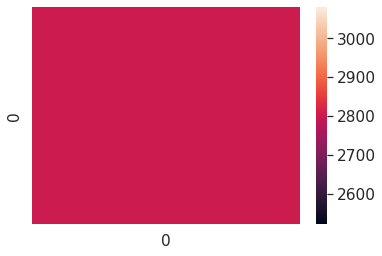

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

print(authors_to_analyze)
print(pred)

confusion = sklearn.metrics.confusion_matrix(actual, pred)

df_cm = pd.DataFrame(confusion, range(1), range(1))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot_kws={"size": 16}) # font size

In [ ]:
a = [1, 2, 3]
print(a[1:2])

[2]


In [ ]:
gc.collect()

88